Out of curiosity, I trained a simple 7 layer convnet to predict the color from a gray scale image. I used some of my own scripts to easily setup caffe, and I used my transformation, resize and colorconv layers http://github.com/philkr/caffe.git .
The network is essentially a trimmed own version of the first 7 layers of VGG. I couldn't get the network to predict anything but the mean color on regular images, but for MPI Sintel (http://sintel.is.tue.mpg.de/) it seems to colorize nicely. The training took about 2 hours for 40'000 iterations with a batch size of 16 (which is about 1'300 epochs for the tiny sintel dataset with ~500 images).

So let's fire up caffe and look at the network architecture:

In [33]:
%pylab inline
%cd ../src

from caffe_all import *
from util import *
from os import path
caffe.set_mode_gpu()

prototxt = '/tmp/test_c7/deploy.prototxt'
weights = sglob(path.dirname(prototxt)+'/*.caffemodel')[0]
net = caffe.Net(prototxt, weights, caffe.TEST)
print(open(prototxt,'r').read())

Populating the interactive namespace from numpy and matplotlib
/home/philkr/workspace/aenc/src
input: "gray"
input_shape {
  dim: 1
  dim: 1
  dim: 100
  dim: 100
}
layer {
  name: "conv0_0"
  type: "Convolution"
  bottom: "gray"
  top: "conv0_0"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 16
    pad: 1
    kernel_size: 3
    group: 1
    stride: 1
    weight_filler {
      type: "gaussian"
      mean: 0
      std: 0.1
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu0_0"
  type: "ReLU"
  bottom: "conv0_0"
  top: "conv0_0"
  relu_param {
    negative_slope: 0.0
  }
}
layer {
  name: "conv0_1"
  type: "Convolution"
  bottom: "conv0_0"
  top: "conv0_1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 16
    pad: 1
    kernel_size: 3
    group: 1
    stride: 1
    weight_fi

Next, let's load some random internet images, together with some sintel images.

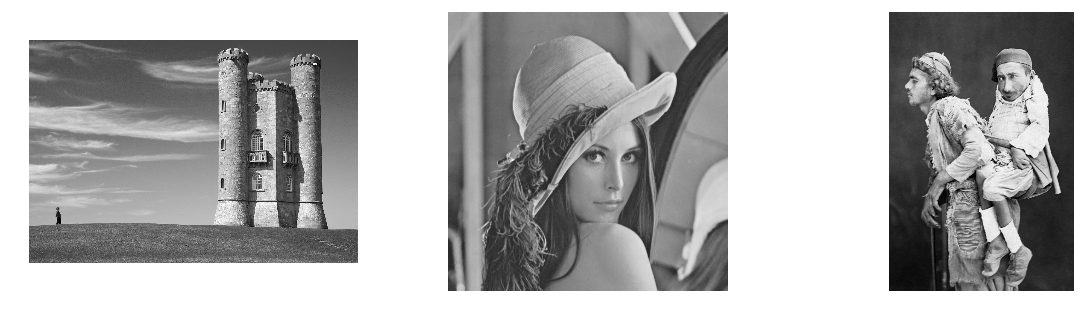

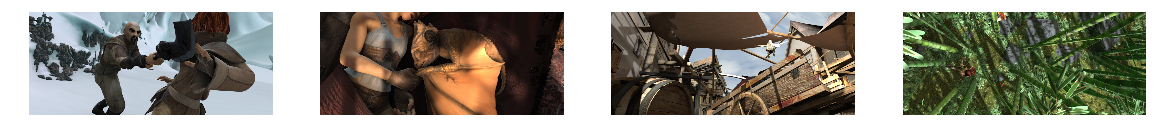

In [39]:
import urllib
images = ['https://upload.wikimedia.org/wikipedia/commons/f/f2/Broadway_tower_grayscale.jpg','http://eeweb.poly.edu/~yao/EL5123/image/lena_gray.bmp','https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Blind_man_carrying_a_paralysed_man.jpg/507px-Blind_man_carrying_a_paralysed_man.jpg']
imgs = []

N = len(images)
figure(figsize=(20,5))
for i,url in enumerate(images):
    I = imread(urllib.request.urlopen(url),format=url.split('.')[-1])
    if len(I.shape) > 2:
        I = np.mean(I,axis=2)
    imgs.append( I )
    subplot(1,N,i+1)
    imshow(I,cmap='gray',vmin=0, vmax=255); axis('off');

images = ['/data/sintel_intrinsic/images/clean/ambush_2/frame_0001.png', '/data/sintel_intrinsic/images/clean/sleeping_1/frame_0024.png', '/data/sintel_intrinsic/images/clean/market_6/frame_0024.png', '/data/sintel_intrinsic/images/clean/bamboo_1/frame_0024.png']

N = len(images)
figure(figsize=(20,5))
for i,url in enumerate(images):
    I = imread(url)
    subplot(1,N,i+1)
    imshow( I ); axis('off')
    from skimage import color
    imgs.append( color.rgb2gray(I)*255 )

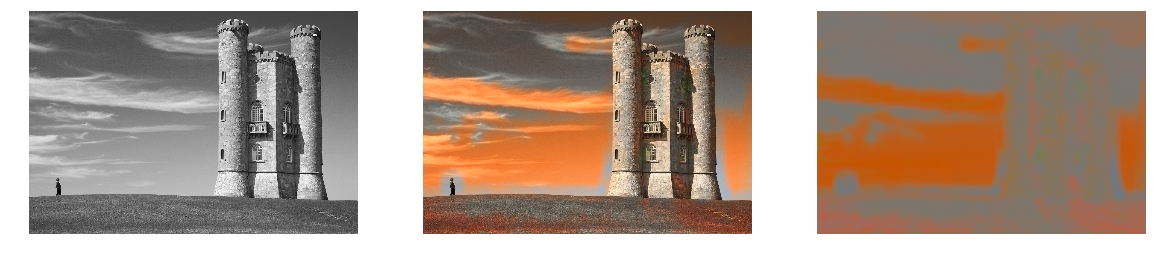

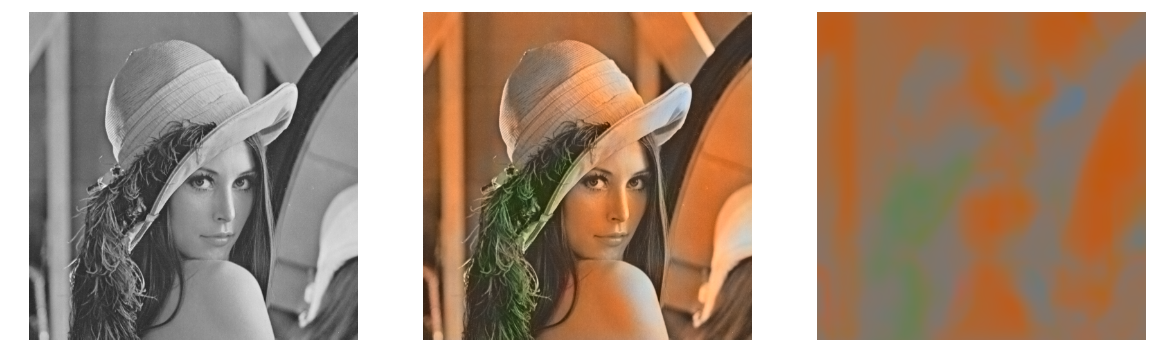

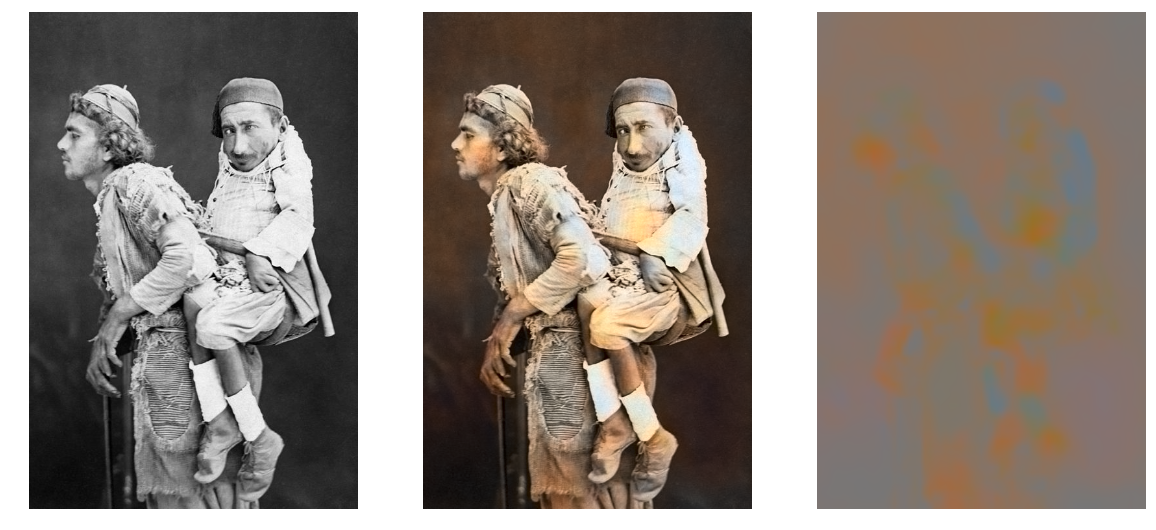

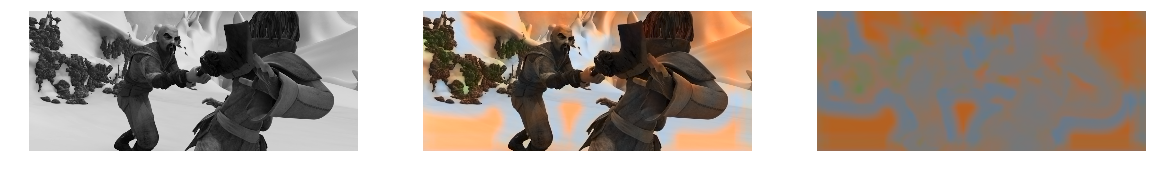

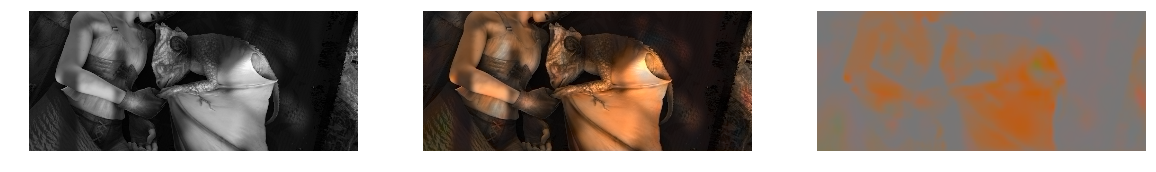

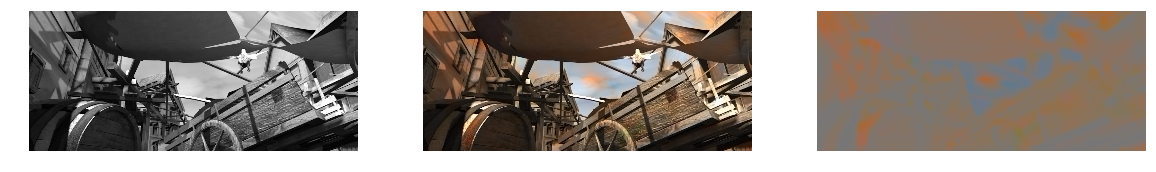

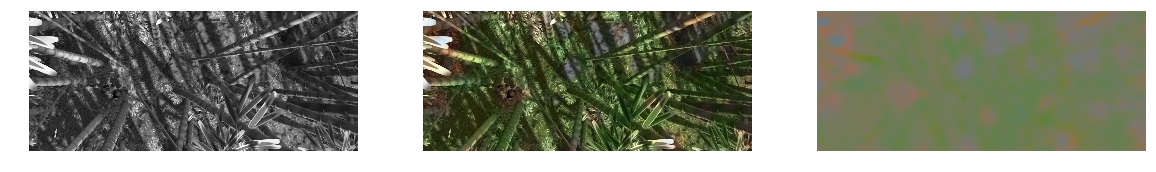

In [40]:
for I in imgs:
    net.blobs['gray'].reshape(1,1,*I.shape)
    net.blobs['gray'].data[...] = I[None,None]
    out = net.forward()
    figure(figsize=(20,10))
    subplot(1,3,1)
    imshow(I, cmap='gray', vmin=0, vmax=255); axis('off');
    subplot(1,3,2)
    imshow(np.minimum(1,np.maximum(0,out['pred_bgr'][0,::-1].transpose([1,2,0])/255.))); axis('off');
    subplot(1,3,3)
    ab = net.blobs['Resize1'].data[0].transpose([1,2,0])
    lab = np.ones(ab.shape[:2]+(3,))*50
    lab[:,:,1:] = ab
    from skimage import color
    imshow(np.minimum(1,np.maximum(0,color.lab2rgb(lab)))); axis('off');

In conclusion, while the coloring somewhat works, it mainly just add the two common colors of sintel (green and orange), and doesn't do much beyond this. In summary this has been a little disapointing.